In [27]:
import os
import pandas as pd
import sqlite3 as sqlite
import numpy as np
import random


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_predict, cross_val_score
import pickle

In [2]:
DATADIR = '../stats_data'
DB = os.path.join(DATADIR, 'Reference Standard', 'radiology_reports.sqlite')
os.path.exists(DB)

True

# Introduction
This notebook is an expansion on `Report Classification.ipynb`. That notebook aimed to test a number of ML classifiers with different hyperparemeters on a task of document classification. That found that the highest-performing algorithm for our task was a `Random Forest Classifier` with the sqrt of features, 200 estimators, and no maximum depth.

**TODO**: Will compare more, update this.

This notebook will aim to compare this classifier with a lower performing algorithm, the `Multinomial Naive Bayes`. We will follow methods laid out here:
https://www.cs.waikato.ac.nz/ml/publications/2003/bouckaert-calibrated-tests.pdf

# Data Preparation
Instead of using test/train splits, this notebook will use cross-validation in order to maximize the amount of data for each fold.

In [3]:
conn = sqlite.connect(DB)

# Training data
train_df = pd.read_sql("SELECT * FROM training_notes;", conn)
#Testing data
test_df = pd.read_sql("SELECT * FROM testing_notes;", conn)
conn.close()

In [5]:
df = train_df.append(test_df)
df.head()

,rowid,name,text,referenceXML,doc_class,subject,HADM_ID,CHARTDATE
0,1,No_10792_131562_05-29-20,\n CT ABDOMEN W/CONTRAST; CT PELVIS W/CONTRAS...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,32,131562,05-29-20
1,2,No_11050_126785_11-03-33,\n CT CHEST W/CONTRAST; CT ABDOMEN W/CONTRAST...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,34,126785,11-03-33
2,3,No_11879_166554_06-22-37,\n CTA CHEST W&W/O C &RECONS; CT 100CC NON IO...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,35,166554,06-22-37
3,4,No_11879_166554_06-23-37,\n CT ABDOMEN W/O CONTRAST; CT PELVIS W/O CON...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,35,166554,06-23-37
4,5,No_11879_166554_07-02-37,\n CT CHEST W/O CONTRAST \n ~ Reason: r/o ste...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,35,166554,07-02-37


In [6]:
vectorizer = TfidfVectorizer(min_df=0.1, lowercase=True, stop_words='english',
                                     ngram_range=(1, 3))
X = list(df.text)
y = list(df.doc_class)

# Fit the vectorizer and transform the training notes into a vector
X = vectorizer.fit_transform(X)

In [7]:
X, y = shuffle(X, y)

# Train Models
We will now instantiate our classifiers that we want to compare.

- Optimal RandomForestClassifier: highest-performing model from our last experiment
- Dummy Classifier: Randomly predicts based on class distribution
- Naive bayes
- Low RandomForestClassifier: lowest-performing RFC
- Logistic Regression - highest-performing Logistic Regression classifier
- SVM
- Lowest - the lowest non-zero performing ML classifier

In [69]:
forest = RandomForestClassifier(n_estimators=200, max_depth=None, max_features='sqrt', n_jobs=-1)
low_forest = RandomForestClassifier(n_estimators=1000, max_features='sqrt', max_depth=50)
naive = MultinomialNB()
dummy = DummyClassifier()
lowest = LogisticRegression(penalty='l1', C=0.1)

clfs = [("Dummy Classifier", dummy), ("Lowest Forest", low_forest), ("Naive Bayes", naive), ("Worst Model", lowest)]

# Experiment
We will now follow a number of different methods for comparing the performance of these algorithms.

### k-fold cross validation
(see paper)
"""
**Summary**: In k-fold cross validation, the data is split in k equal parts. The algorithm is then trained on all data but one fold. That remaining fold is used to test. This gives us *k* accuracy estimates for algorithms A and B.

xi is the difference between the two accuracies. The mean x is normally distributed if the algortihms are the same and the folds are sufficiently large.

We have a statistic approximating the t distribution with df = k - 1 degrees of freedom.
"""

In this section, we will do 10-fold cross-validation, which returns an array of 10 F1 scores for each classifer. For each of the non-optimal classifiers (not the Random Forest that we determined was the highest-performing model in the last notebook), we will compare the two arrays of F1 scores and see if they are significantly different.

In [76]:
# Now do a t-test
from scipy.stats import ttest_ind as ttest

def compare_model_results(clf1, clf2, X, y, k=10):
    """
    Compares the cross-validated accuracy scores of two different classifiers
    using a student's t-test.
    Returns the results of the t-test
    clf1: the first classifier
    clf2: the second classifier
    """
    results1 = cross_val_score(clf1, X, y, cv=k, scoring='f1')
    results2 = cross_val_score(clf2, X, y, cv=k, scoring='f1')
    
    return ttest(results1, results2)
    

In [77]:
results = []

In [78]:
for (name, clf) in clfs:
    print(name)
    t = compare_model_results(forest, clf, X, y, k=10)
    pvalue = t.pvalue
    results.append((name, pvalue))
    


Dummy Classifier
Lowest Forest
Naive Bayes
Worst Model


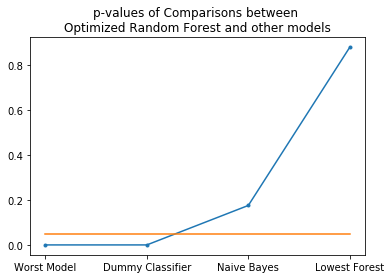

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
sorted_results = sorted(results, key=lambda x:x[1], reverse=False)
names, pvalues = zip(*sorted_results)
ax.plot(range(len(pvalues)), pvalues, marker='.')
ax.plot(range(len(pvalues)), [0.05 for i in range(len(pvalues))])
ax.set_title("p-values of Comparisons between \nOptimized Random Forest and other models")
_ = plt.xticks(range(len(pvalues)), names)